## REFIT Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (25, 15)
plt.rcParams.update({'font.size': 22})

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from keras.metrics import RootMeanSquaredError

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [5]:
path="/Users/daniel.bustillo/Documents/thesis/REFIT"
os.chdir(path)

In [6]:
# list_of_names= []
# list_of_names=os.listdir(path)


  
# # create empty list
# dataframes_list = []
  
# # append datasets into teh list
# for i in range(len(list_of_names)):
#     temp_df = pd.read_csv(list_of_names[i], parse_dates=True, index_col=0, infer_datetime_format=True)
#     dataframes_list.append(temp_df)
# dataframes_list = [df.resample("1H").mean() for df in dataframes_list]
# dataframes_list = [df.drop(['Unix','Issues'], axis=1) for df in dataframes_list]

# dataframes_list = [i.loc[:,"Aggregate"] for i in dataframes_list]
    
# refit= pd.concat(dataframes_list, axis=1)
# refit.columns = np.arange(len(refit.columns))
# refit= refit.add_prefix("house_")


# refit= refit.loc[refit.index >"07-03-2014"].copy()


# # refit= refit.loc[refit.index<="05-01-2015"].copy()
# # refit.to_csv("refit_all.csv")

In [7]:
refit= pd.read_csv("refit_all.csv", parse_dates=True, index_col=0)

## EDA and Plots

In [16]:
refit1 = refit.copy()
refit1['hour'] = refit1.index.hour
refit1['weekday'] = refit1.index.weekday
avg= refit1.groupby(['hour','weekday']).mean()['house_10']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","house_10")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in House 10 (in Watts)')

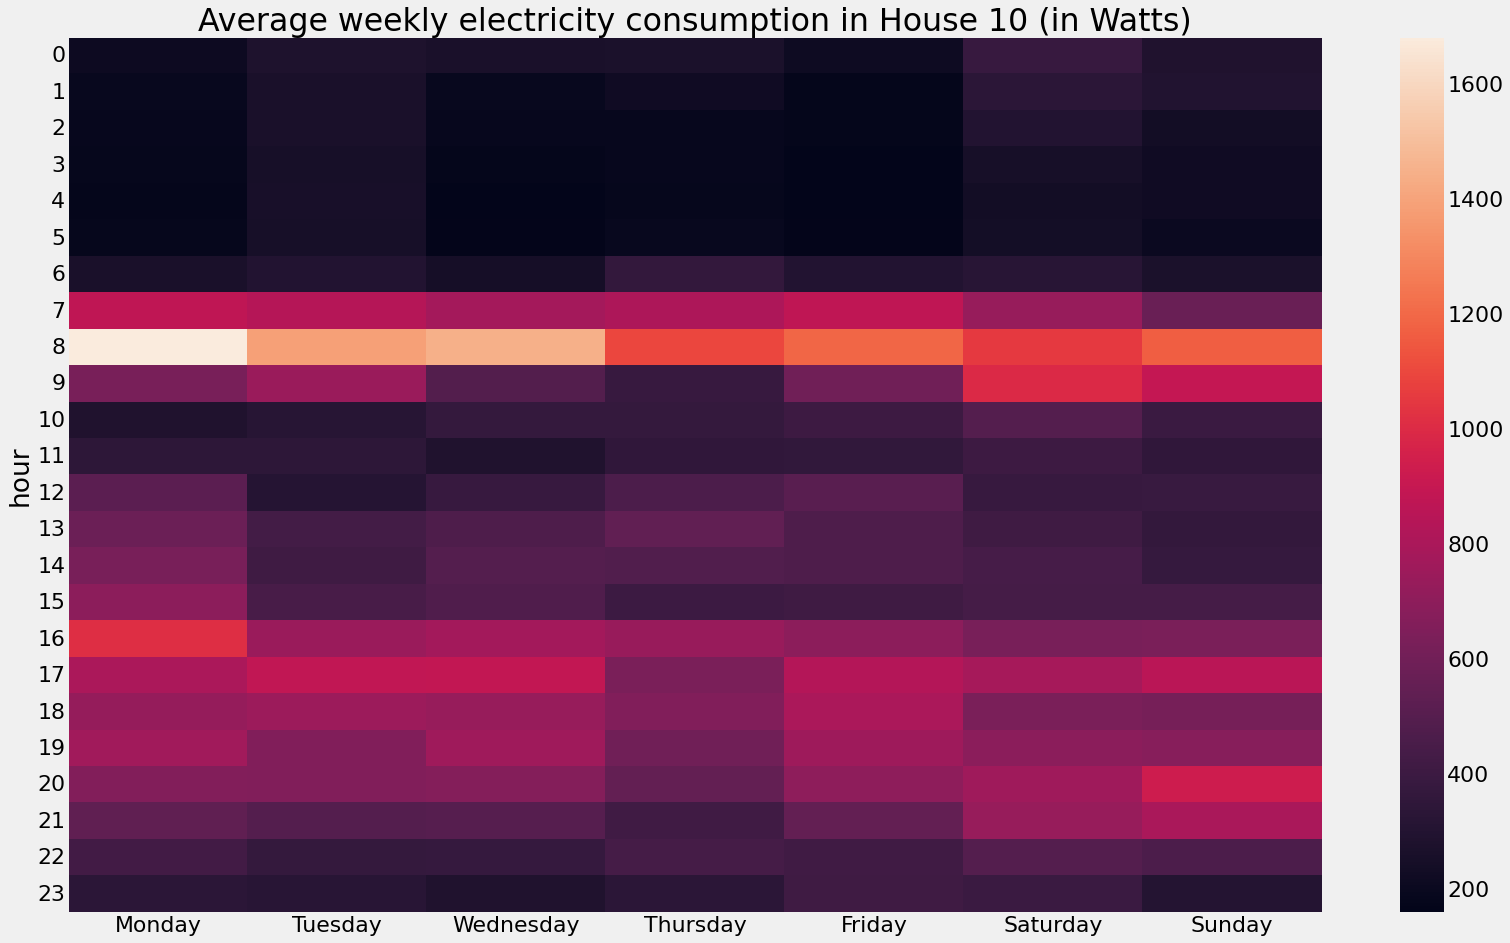

In [17]:
g=sns.heatmap(avg_pivot)

locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in House 10 (in Watts)")

<AxesSubplot:title={'center':'Electricity consumption of 6 sampled houses'}, xlabel='Time', ylabel='Load (in Watts)'>

<Figure size 1800x1080 with 0 Axes>

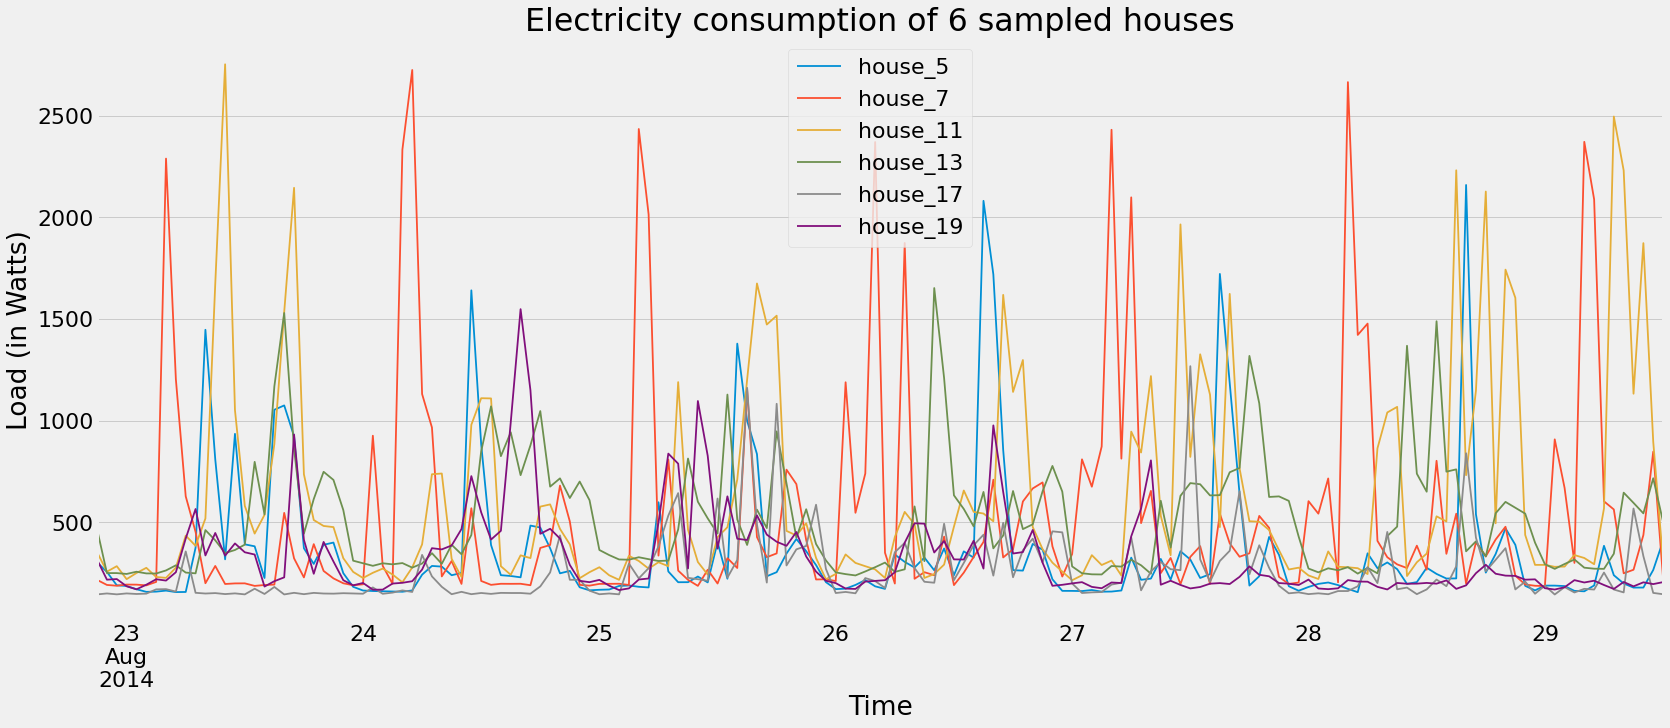

In [123]:
plt.figure()
plt.rcParams.update({'font.size': 22})
refit1.iloc[1220:1380,[5,7,11,13,17,19]].plot(subplots=False, title="Electricity consumption of 6 sampled houses", lw=1.8, 
ylabel="Load (in Watts)", figsize=(25,10))


array([[<AxesSubplot:title={'center':'house_0'}>,
        <AxesSubplot:title={'center':'house_1'}>,
        <AxesSubplot:title={'center':'house_2'}>,
        <AxesSubplot:title={'center':'house_3'}>],
       [<AxesSubplot:title={'center':'house_4'}>,
        <AxesSubplot:title={'center':'house_5'}>,
        <AxesSubplot:title={'center':'house_6'}>,
        <AxesSubplot:title={'center':'house_7'}>],
       [<AxesSubplot:title={'center':'house_8'}>,
        <AxesSubplot:title={'center':'house_9'}>,
        <AxesSubplot:title={'center':'house_10'}>,
        <AxesSubplot:title={'center':'house_11'}>],
       [<AxesSubplot:title={'center':'house_12'}>,
        <AxesSubplot:title={'center':'house_13'}>,
        <AxesSubplot:title={'center':'house_14'}>,
        <AxesSubplot:title={'center':'house_15'}>],
       [<AxesSubplot:title={'center':'house_16'}>,
        <AxesSubplot:title={'center':'house_17'}>,
        <AxesSubplot:title={'center':'house_18'}>,
        <AxesSubplot:title={'center':

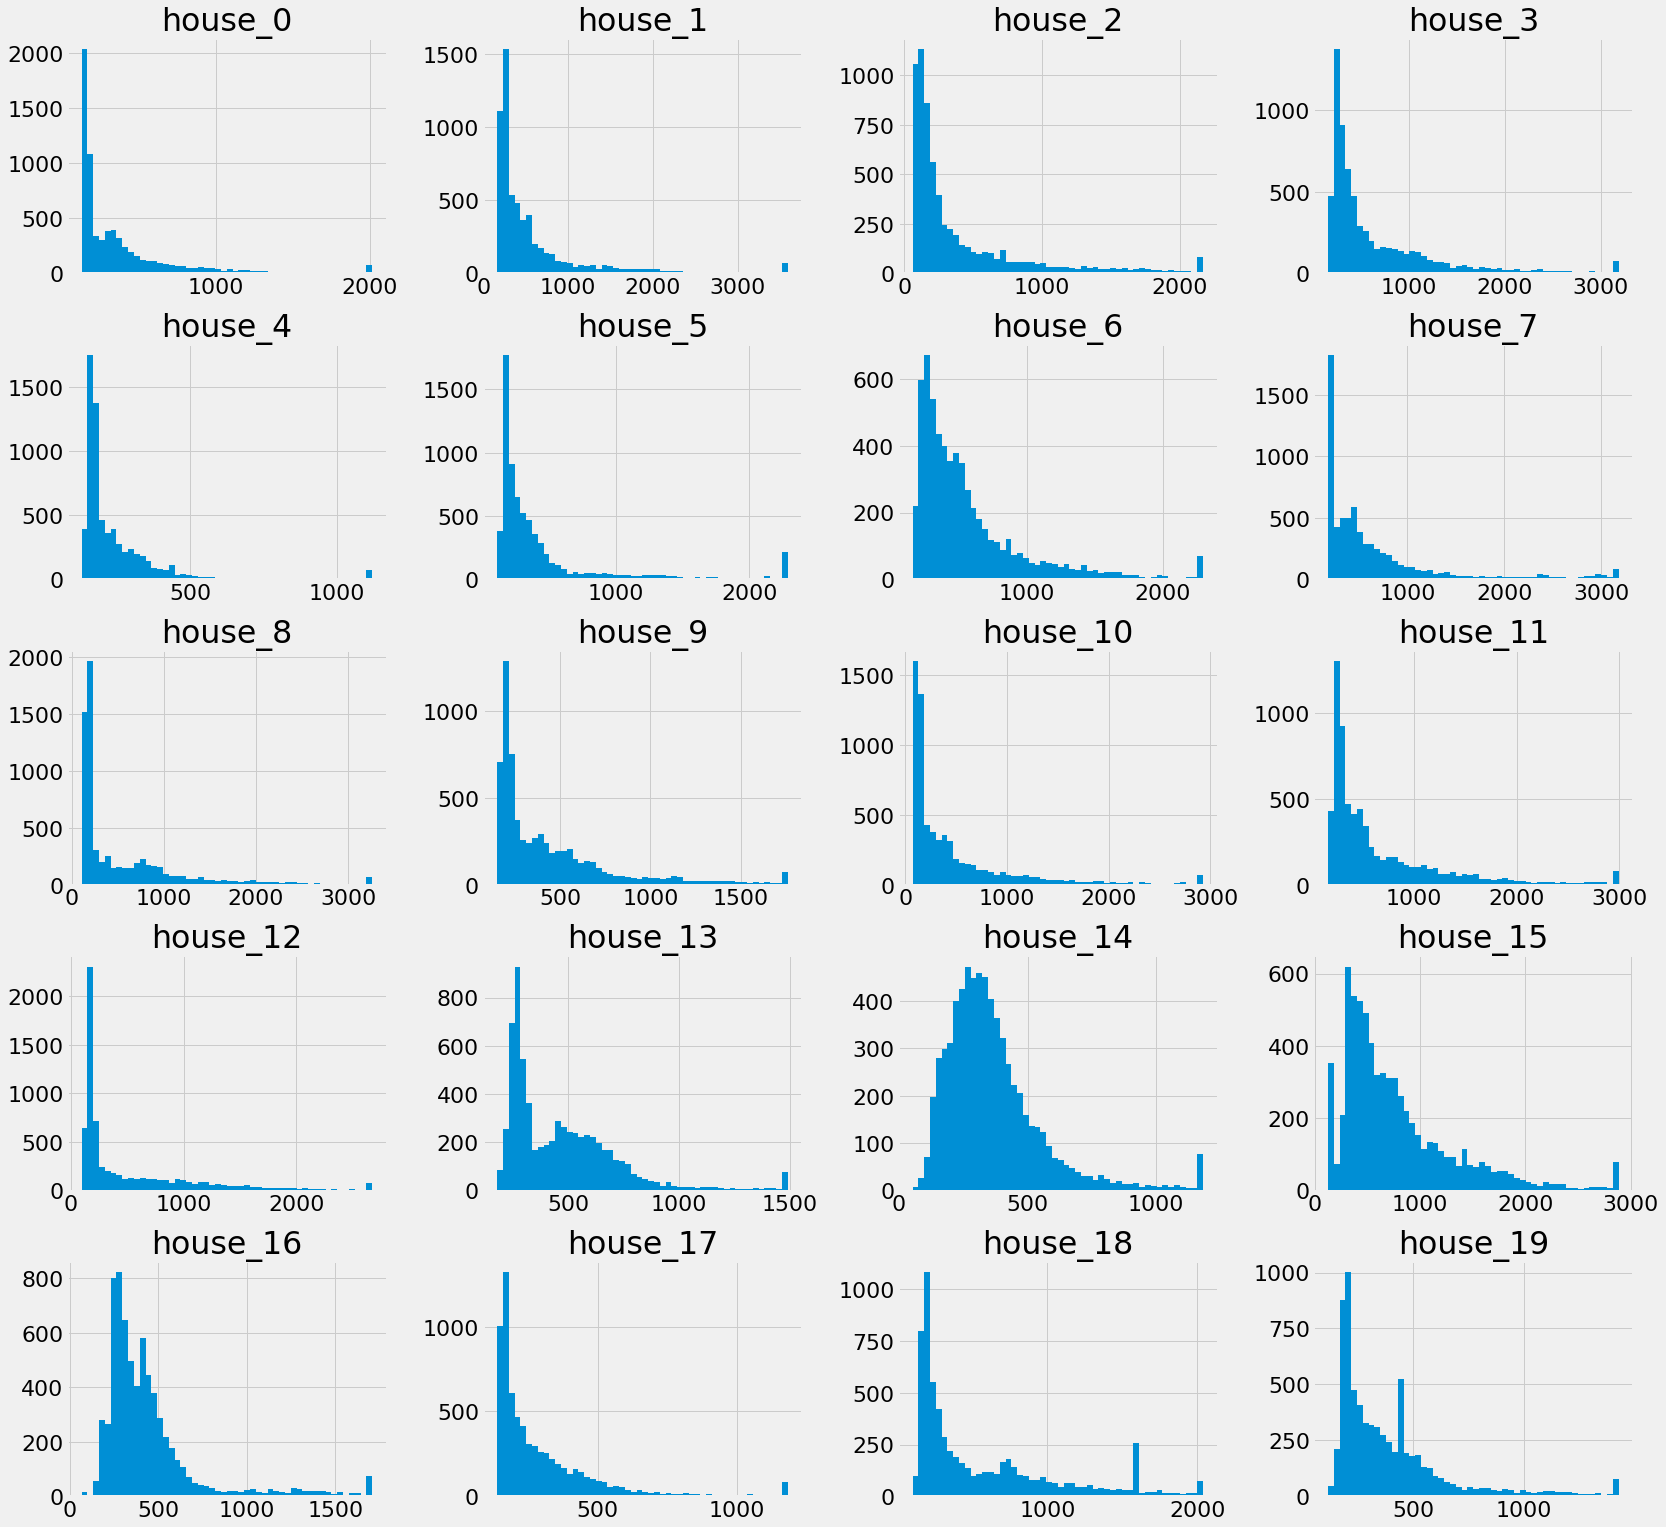

In [76]:
refit.hist(bins=50, figsize=(25,25))

In [8]:
for home in refit:
    q_99 = refit[home].quantile(0.99)

    refit[home] = np.where(refit[home]>=q_99, q_99, refit[home])



In [77]:
def create_features(df):
    """
    Creates time series features from datetime index.
    """
    # df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night']= np.where((df['hour']>=18)|(df['hour']<6),1,0)
    df['lag_hour'] = df['Aggregate'].shift(periods=1)
    df['lag_day'] = df['Aggregate'].shift(periods=24)
    df['lag_week'] = df['Aggregate'].shift(periods=168)


# Univariate Benchmark example

In [9]:
    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
    
    def mape(y_true, y_score):
        error = mean_absolute_percentage_error(y_true, y_score)
        return error

In [10]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [11]:
pred_train = {}
pred_test = {}

rmse_train={}
rmse_test = {}

mape_train = {}
mape_test = {}

In [89]:
def run_model(home: pd.Series, train_size, timesteps= 1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
    print(home.name)
    #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(256))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    




    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    if plot ==True:

        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'simple_lstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

    mape_test[f'single){home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    mape_train[f'single){home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

In [13]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, n_features=1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
    print(home.name)
    #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
    conv.add(MaxPooling1D(pool_size=1))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"convlstm_{home.name}"] = scaler.inverse_transform(
                                conv.predict(X_train,verbose=0)).flatten()

    pred_test[f'convlstm_{home.name}'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

    if plot==True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'convlstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'conv_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    rmse_train[f'conv_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

    mape_test[f'conv_{home.name}'] = mape(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    mape_train[f'conv_{home.name}'] = mape(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'conv_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'conv_{home.name}']}")



    


    

# Hyperparameter Tuning

In [14]:
#install the package
import keras_tuner as kt
import keras.optimizers


In [17]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice('units',[24,64,128,256,512])))
  model.add(Dense(1, activation='relu'))
  model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate',[0.0001,0.001,0.01])), metrics=['mean_squared_error'])

  
  return model

In [18]:
tuner = kt.RandomSearch(
    build_model,
    objective= 'val_mean_squared_error',
    max_trials=20,
    executions_per_trial= 2,
    overwrite=True)

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 24, 'conditions': [], 'values': [24, 64, 128, 256, 512], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [21]:
timesteps=1

In [22]:
home= refit['house_0']
home= home.dropna()


# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.9, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [23]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 12 Complete [00h 01m 11s]
val_mean_squared_error: 0.02664312720298767

Best val_mean_squared_error So Far: 0.026421750895678997
Total elapsed time: 00h 06m 32s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.results_summary()
# Trial summary
# Hyperparameters:
# units: 256
# learning_rate: 0.01
# Score: 0.026421750895678997

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.01
Score: 0.026421750895678997
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.001
Score: 0.026553609408438206
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.001
Score: 0.026569959707558155
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.0001
Score: 0.02664312720298767
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.01
Score: 0.03919405769556761
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
Score: 0.039217736572027206
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.0392885310575366
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.039299204014241695
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.0001
Score: 0.039354972541332245
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.001
Score: 0.03935842588543892


# Naive Multivariate LSTM approach

In [33]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [34]:
values= refit.values
values = values.astype('float32')

In [35]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [36]:
#Testing house1 
house_1= reframed.iloc[:,:21]
house_2=reframed.iloc[:,np.r_[0:19,21]]
house_3= reframed.iloc[:,np.r_[0:19,22]]
house_4= reframed.iloc[:,np.r_[0:19,23]]
house_5= reframed.iloc[:,np.r_[0:19,24]]
house_6= reframed.iloc[:,np.r_[0:19,25]]
house_7= reframed.iloc[:,np.r_[0:19,26]]
house_8= reframed.iloc[:,np.r_[0:19,27]]
house_9= reframed.iloc[:,np.r_[0:19,28]]
house_10= reframed.iloc[:,np.r_[0:19,29]]
house_11= reframed.iloc[:,np.r_[0:19,30]]
house_12= reframed.iloc[:,np.r_[0:19,31]]
house_13= reframed.iloc[:,np.r_[0:19,32]]
house_14= reframed.iloc[:,np.r_[0:19,33]]
house_15= reframed.iloc[:,np.r_[0:19,34]]
house_16= reframed.iloc[:,np.r_[0:19,35]]
house_17= reframed.iloc[:,np.r_[0:19,36]]
house_18= reframed.iloc[:,np.r_[0:19,37]]
house_19= reframed.iloc[:,np.r_[0:19,38]]
house_20= reframed.iloc[:,np.r_[0:19,39]]



In [37]:
housess = [house_1, house_2, house_3, house_4, house_5, house_6, house_7, house_8, house_9, house_10, house_11, house_12, house_13, house_14, house_15,
        house_16, house_17, house_18, house_19, house_20]

In [38]:
housenames =[]
for i in range(1,21):
    x= f"house_{i}"
    housenames.append(x)

In [39]:
houses = dict(zip(housenames, housess))


In [43]:
def train_multimodel(df, train_size = 0.8, neurons = 256, epochs=50, batch_size=24, plot=True):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean squared_error'''    
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    if plot==True:

        # plot history
        plt.plot(history2.history['loss'], label='train')
        #plt.plot(history2.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    else:
        pass

    multi_pred_train={}
    multi_pred_test={}

    multi_rmse_train={}
    multi_rmse_test={}

    multi_mape_train={}
    multi_mape_test={}
    
    #Predict on both sets
    yhat_test= model.predict(X_test)
    yhat_train = model.predict(X_train)

    #Reshape them to fit the right format to inverse_transform
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))

    inv_yhat_test= np.concatenate((X_test, yhat_test), axis=1)
    inv_yhat_train=np.concatenate((X_train, yhat_train), axis=1)

    inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)

    multi_pred_test['multi'] = inv_yhat_test[:,-1]
    multi_pred_train['multi'] = inv_yhat_train[:,-1]

    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    y_train = y_train.reshape(len(y_train),1)

    inv_y_test= np.concatenate((X_test, y_test), axis=1)
    inv_y_train= np.concatenate((X_train, y_train), axis=1)

    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_train = scaler.inverse_transform(inv_y_train)

    multi_pred_test['true'] = inv_y_test[:,-1]
    multi_pred_train['true'] = inv_y_train[:,-1]


    multi_rmse_test['multi'] = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
    multi_rmse_train['multi'] = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    multi_mape_test['multi'] = mape(inv_y_test, inv_yhat_test)
    multi_mape_train['multi'] = mape(inv_y_train, inv_yhat_train)

    print(multi_rmse_test)

    multi_pred_test = pd.DataFrame(multi_pred_test)

    if plot==True:
        multi_pred_test.plot(lw=1.5)
    else:
        pass


    return multi_pred_train, multi_pred_test, multi_rmse_train, multi_rmse_test, multi_mape_train, multi_mape_test

In [45]:
for value in houses.values():
    multi_pred_train, multi_pred_test, multi_rmse_train, multi_rmse_test, multi_mape_train, multi_mape_test= train_multimodel(value, epochs=10, plot=False)

(3864, 1, 20) (3864,) (966, 1, 20) (966,)
Epoch 1/10
161/161 - 2s - loss: 0.0272 - 2s/epoch - 11ms/step
Epoch 2/10
161/161 - 0s - loss: 0.0254 - 444ms/epoch - 3ms/step
Epoch 3/10
161/161 - 0s - loss: 0.0250 - 436ms/epoch - 3ms/step
Epoch 4/10
161/161 - 0s - loss: 0.0249 - 429ms/epoch - 3ms/step
Epoch 5/10
161/161 - 0s - loss: 0.0248 - 428ms/epoch - 3ms/step
Epoch 6/10
161/161 - 0s - loss: 0.0248 - 432ms/epoch - 3ms/step
Epoch 7/10
161/161 - 0s - loss: 0.0247 - 430ms/epoch - 3ms/step
Epoch 8/10
161/161 - 0s - loss: 0.0246 - 424ms/epoch - 3ms/step
Epoch 9/10
161/161 - 0s - loss: 0.0246 - 425ms/epoch - 3ms/step
Epoch 10/10
161/161 - 0s - loss: 0.0245 - 422ms/epoch - 3ms/step
{'multi': 65.195854}
(3856, 1, 19) (3856,) (965, 1, 19) (965,)
Epoch 1/10
161/161 - 3s - loss: 0.0216 - 3s/epoch - 19ms/step
Epoch 2/10
161/161 - 1s - loss: 0.0198 - 749ms/epoch - 5ms/step
Epoch 3/10
161/161 - 1s - loss: 0.0189 - 880ms/epoch - 5ms/step
Epoch 4/10
161/161 - 1s - loss: 0.0186 - 546ms/epoch - 3ms/step
Ep

# Federated version

In [134]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error

In [135]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [136]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

def mape(y_true,y_score):
    error = mean_absolute_percentage_error(y_true, y_score)
    return error
    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds= model.predict(X_test)
    loss = rmse(Y_test, preds)
    scaled_preds = scaler.inverse_transform(preds)
    scaled_loss = rmse(scaler.inverse_transform(Y_test), scaled_preds)
    print('comm_round: {} |loss_in_{}: {} | scaled_loss_in_{}: {}'.format(comm_round,home,loss, home, scaled_loss))
    return loss, scaled_loss, preds, scaled_preds

In [137]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test, scaler


In [142]:
comms_round = 50
    
#create optimizer
lr = 0.01 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [143]:
client_names = refit.columns

In [144]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(256, 1, 1)
        


In [145]:

pred_train={}
pred_test= {}

rmse_train={}
rmse_test={}

mape_train ={}
mape_test ={}
norm_error ={}

In [146]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for house in refit:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(256)
        local_model.compile(loss=loss, 
                        optimizer=optimizer, #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test, scaler= prepare_task(refit[house])


        local_model.fit(X_train, y_train, epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(refit, house)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss, scaled_loss, preds, scaled_preds = test_model(X_test, y_test, global_model, comm_round, house)

        norm_error[f'fed_house_{house}'] = local_loss
        pred_train[f"true_{house}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{house}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"fed_{house}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"fed_{house}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'fed_{house}'] = rmse(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])
        rmse_train[f'fed_{house}'] = rmse(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])

        mape_train[f'fed_{house}'] = mape(pred_train[f'true_{house}'], pred_train[f'fed_{house}'])
        mape_test[f'fed_{house}'] = mape(pred_test[f'true_{house}'], pred_test[f'fed_{house}'])

        # #plot the predictions
        # plt.plot(pred_test[f'true_{home}'])
        # plt.plot(pred_test[f'simple_lstm_{home}'])
        # plt.show()

        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 |loss_in_house_0: 0.22898975768852975 | scaled_loss_in_house_0: 433.7298698338094
comm_round: 0 |loss_in_house_1: 0.17559370261387638 | scaled_loss_in_house_1: 602.1108065144409
comm_round: 0 |loss_in_house_2: 0.40312060491907425 | scaled_loss_in_house_2: 849.9020480610349
comm_round: 0 |loss_in_house_3: 0.22853939487733113 | scaled_loss_in_house_3: 691.6958504484985
comm_round: 0 |loss_in_house_4: 0.130743261228765 | scaled_loss_in_house_4: 129.18966109593728
comm_round: 0 |loss_in_house_5: 0.24753317399465852 | scaled_loss_in_house_5: 537.0802186793758
comm_round: 0 |loss_in_house_6: 0.13723729932384215 | scaled_loss_in_house_6: 292.9641460090355
comm_round: 0 |loss_in_house_7: 0.2635666467137759 | scaled_loss_in_house_7: 790.6972275764352
comm_round: 0 |loss_in_house_8: 0.23787297916130606 | scaled_loss_in_house_8: 750.1340385859614
comm_round: 0 |loss_in_house_9: 0.2983192048217329 | scaled_loss_in_house_9: 479.2057135825289
comm_round: 0 |loss_in_house_10: 0.27528731

In [147]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results1.csv")

In [148]:
pd.DataFrame.from_dict(norm_error, orient ='index').to_csv("norm_results.csv")

# Training of the models

In [149]:
for home in refit:
    run_model(refit[home], train_size=0.8, epochs=50, batch_size=64)

house_0
(5539, 1, 1)
Epoch 1/50
87/87 [==============================] - 5s 15ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 2/50
87/87 [==============================] - 1s 7ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 3/50
87/87 [==============================] - 1s 7ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4/50
87/87 [==============================] - 1s 9ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 5/50
87/87 [==============================] - 1s 7ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 6/50
87/87 [==============================] - 1s 9ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 7/50
87/87 [==============================] - 1s 7ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 8/50
87/87 [==============================] - 1s 9ms/step - lo

In [150]:
for home in refit:
    run_conv_model(refit[home], train_size=0.8, epochs=50, batch_size=64)

house_0
(5539, 1, 1)
Epoch 1/50
87/87 [==============================] - 1s 5ms/step - loss: 0.0270 - val_loss: 0.0261
Epoch 2/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0261
Epoch 3/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0261
Epoch 4/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0261
Epoch 5/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0261
Epoch 6/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 7/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 8/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 9/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0260
Epoch 10/50
87/87 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.026

In [151]:
pd.DataFrame.from_dict(rmse_test,orient='index').to_csv("allresults.csv")

#allresults.csv trained with 50 comm rounds, 50 epochs 

## ARIMA

In [96]:
#ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [98]:
#Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(refit['house_0'].dropna(),autolag="AIC")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -12.300663
p-value: 0.000000


In [99]:
#Time Series split
from sklearn.model_selection import TimeSeriesSplit
tscv= TimeSeriesSplit(n_splits=15,max_train_size=780)

In [100]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [47]:
model= pm.auto_arima(X_train["Aggregate"], seasonal=True, suppress_warnings=True)


In [49]:

preds, conf_int = model.predict(n_periods=X_test.shape[0], return_conf_int=True)

In [52]:
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(X_test['Aggregate'], preds)))

Test RMSE: 0.075


Text(0.5, 0, 'Year')

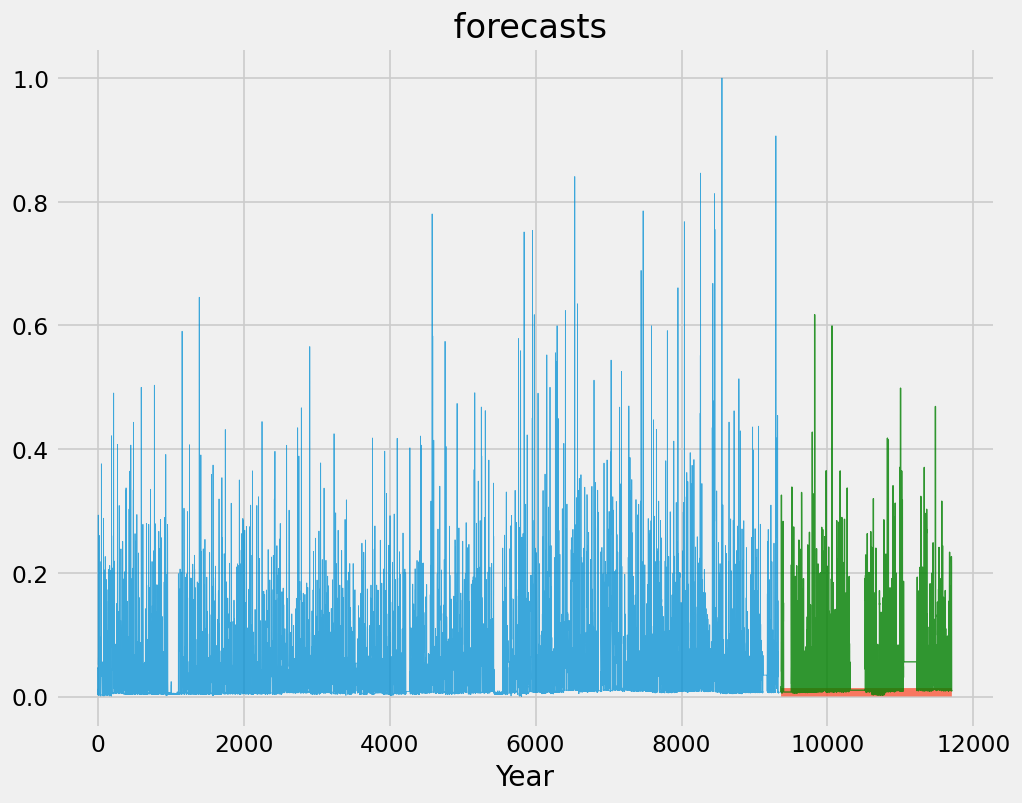

In [53]:
# Plot the points and the forecasts
x_axis = np.arange(X_train.shape[0] + preds.shape[0])
x_years = x_axis 

plt.plot(x_years[x_axis[:X_train.shape[0]]], X_train['Aggregate'], alpha=0.75, lw=0.5)
plt.plot(x_years[x_axis[X_train.shape[0]:]], preds, alpha=0.75, lw=5)  # Forecasts
plt.plot(x_years[x_axis[X_train.shape[0]:]], X_test['Aggregate'],
            alpha=0.8, c="g", lw=0.8)  # Test data
# plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
plt.title(" forecasts")
plt.xlabel("Year")

In [77]:

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    


[ 320.85483871  328.61245675  138.13884007  156.10606061  139.35185185
  163.66331658  176.08658009  162.96367521 1418.65892857  350.1957672
  401.89212329  263.69860627  152.12878788  175.82490975  160.87341772
  135.87114338  131.84162063  143.26775956  143.1261426   131.40699816
  154.96428571 1068.54166667 1272.56672761  529.65280289  140.26691042
  263.44144144  234.12363636  218.00544465  546.15699659  140.09563758
  310.55387205  219.64655172  547.43133803  345.37659963  444.36
  310.26666667  256.26545455  144.14673913  157.25840708  140.03085299
  127.99267399  136.84909091  138.37892791  127.42115028  339.0749543
 1043.04136691 1086.82817869  728.38018018  318.44262295  306.76311031
  867.37163375 1784.13309353  858.42980936  907.99643494  271.16420664
  267.75719424  325.06118881  338.11484099  294.73083779  286.05820106
  196.3540146   136.25090909  131.6024735   137.39927405  139.14981949
  135.28228782  131.6101083   140.93967093  370.61001789  324.70178571
  145.09821429

## Prophet

In [173]:
#Prophet

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [175]:
dataframes_list[0]['Agg_transformed']

Time
2014-03-07 10:00:00    1.129658
2014-03-07 11:00:00    1.129805
2014-03-07 12:00:00    1.121940
2014-03-07 13:00:00    1.123439
2014-03-07 14:00:00    1.122052
                         ...   
2015-07-07 22:00:00    1.131198
2015-07-07 23:00:00    1.124752
2015-07-08 00:00:00    1.123899
2015-07-08 01:00:00    1.124126
2015-07-08 02:00:00    1.124255
Freq: H, Name: Agg_transformed, Length: 11705, dtype: float64

In [182]:
X = dataframes_list[0]

In [183]:
X_train, X_test = train_test_split(X, test_size=0.1, shuffle=False)

In [184]:
X_train['ds']= X_train.index
X_test['ds'] = X_test.index

X_train = X_train[['ds','Agg_transformed']]
X_test = X_test[['ds','Agg_transformed']]

/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_67757/2259697320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ds']= X_train.index
/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_67757/2259697320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ds'] = X_test.index


In [188]:
# Format data for prophet model using ds and y
X_train =X_train.reset_index()
X_train= X_train[['ds','Agg_transformed']]
X_train =X_train.rename(columns={"Agg_transformed":"y"})


In [193]:
model= Prophet(interval_width=0.95,yearly_seasonality=False, weekly_seasonality=True,daily_seasonality=True)
model.fit(X_train)

Initial log joint probability = -2.14227


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56180.8   0.000450998       14647.4        0.53        0.53      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       56201.3   0.000492814       3501.14           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       56211.1    0.00013198       10232.5           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       56221.5   1.90669e-06       2740.34      0.3105      0.3105      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       56233.4   8.44491e-05       6847.05      0.6656      0.6656      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599    

In [194]:
prediction = model.predict(X_test)

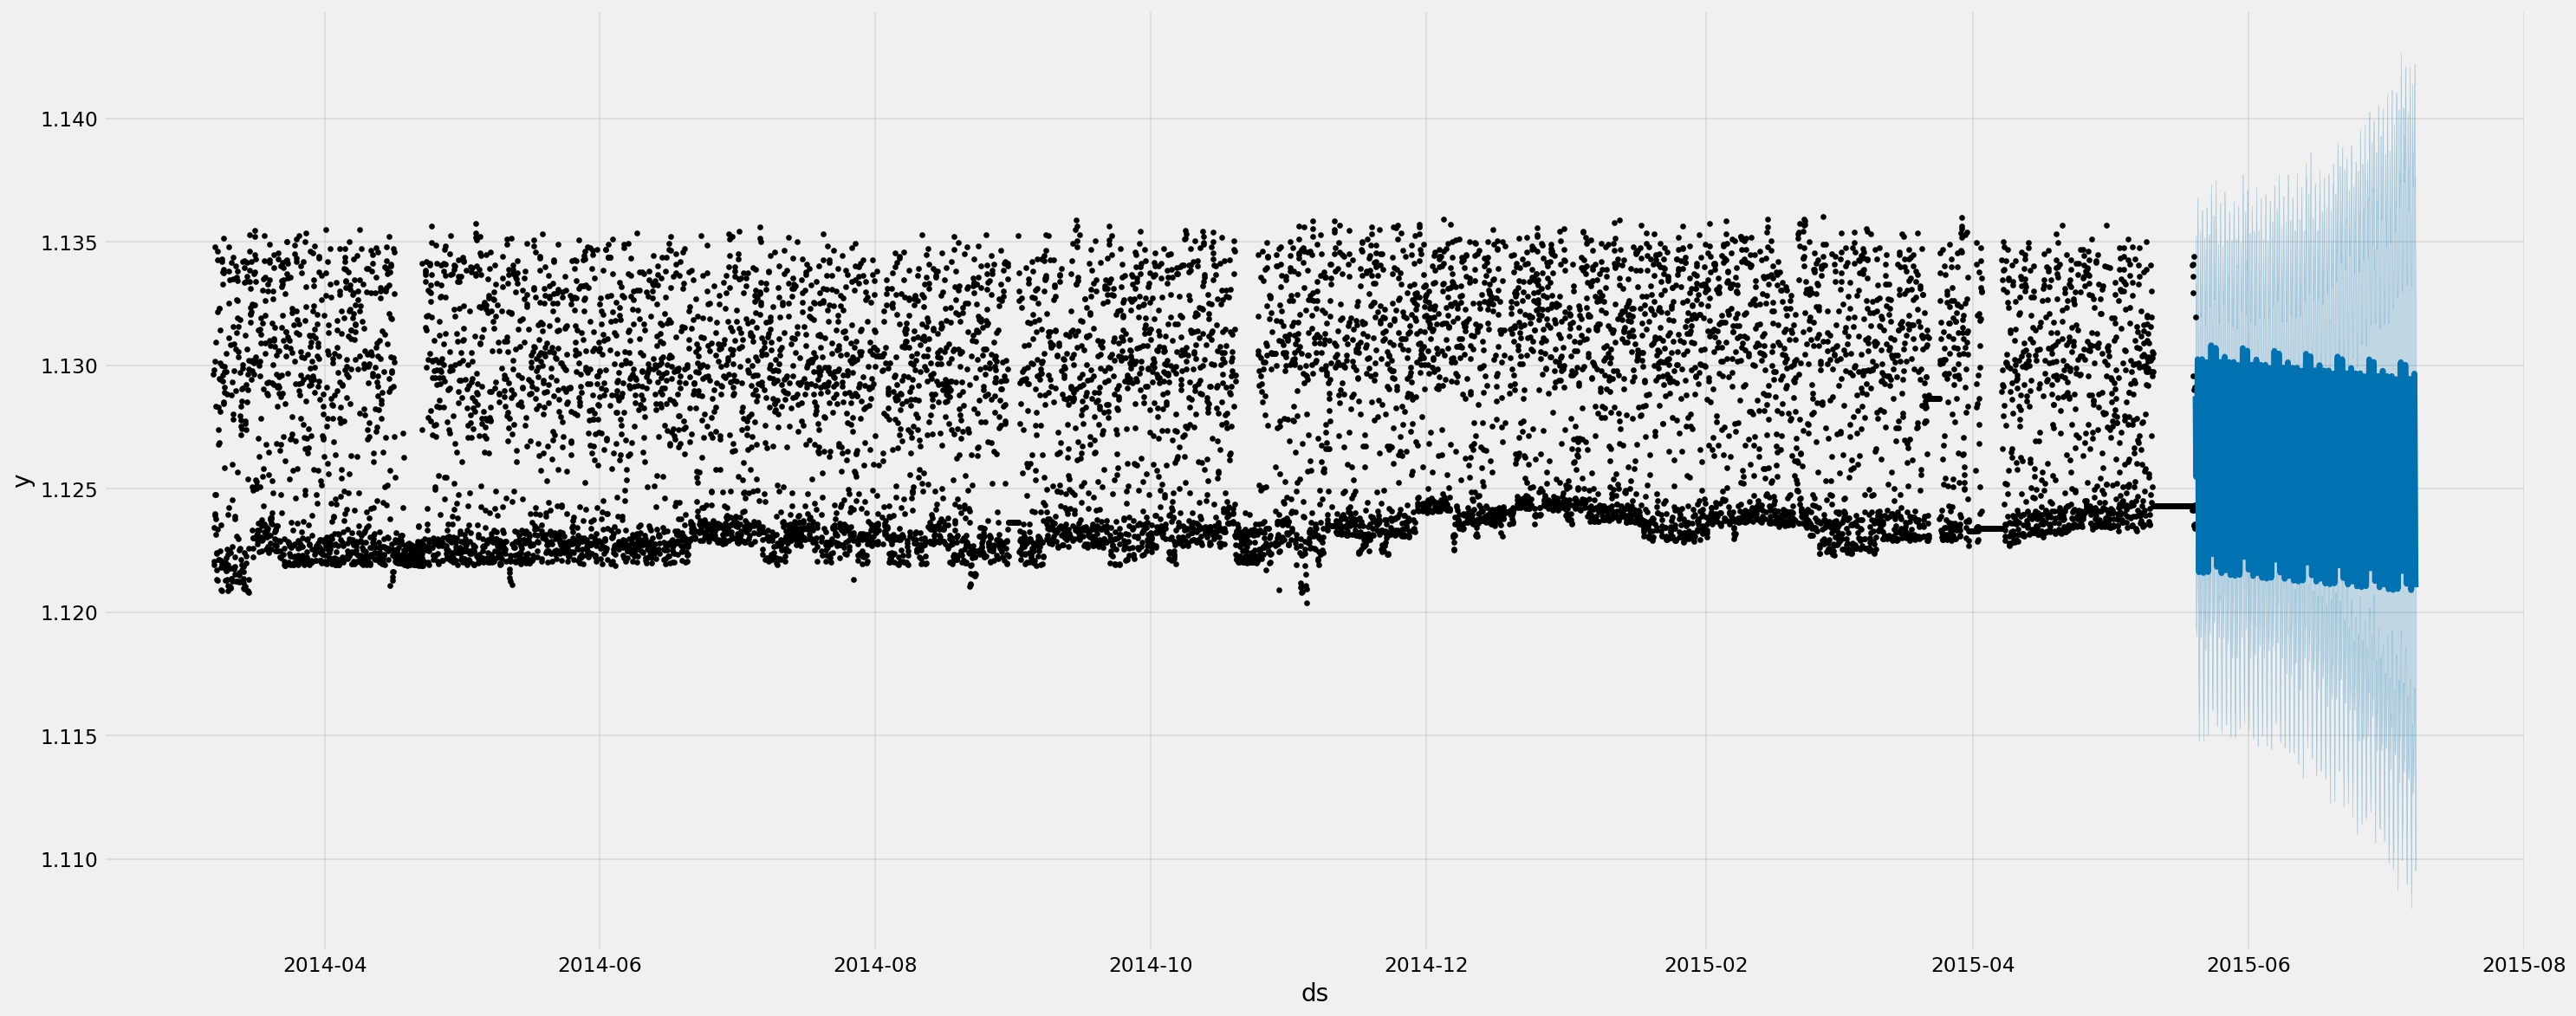

In [195]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(25)
fig = model.plot(prediction,
                 ax=ax)
plt.show()

In [196]:
type(prediction)

pandas.core.frame.DataFrame

In [209]:
prediction.index= prediction.ds

In [210]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2015-05-20 08:00:00,2015-05-20 08:00:00,1.126385,1.122377,1.135244,1.126385,1.126385,0.002363,0.002363,0.002363,0.002440,0.002440,0.002440,-0.000077,-0.000077,-0.000077,0.0,0.0,0.0,1.128747
2015-05-20 09:00:00,2015-05-20 09:00:00,1.126384,1.120714,1.133504,1.126384,1.126384,0.001231,0.001231,0.001231,0.001321,0.001321,0.001321,-0.000089,-0.000089,-0.000089,0.0,0.0,0.0,1.127615
2015-05-20 10:00:00,2015-05-20 10:00:00,1.126383,1.119377,1.132595,1.126383,1.126383,-0.000147,-0.000147,-0.000147,-0.000047,-0.000047,-0.000047,-0.000101,-0.000101,-0.000101,0.0,0.0,0.0,1.126236
2015-05-20 11:00:00,2015-05-20 11:00:00,1.126383,1.119549,1.131978,1.126383,1.126383,-0.000898,-0.000898,-0.000898,-0.000786,-0.000786,-0.000786,-0.000112,-0.000112,-0.000112,0.0,0.0,0.0,1.125484
2015-05-20 12:00:00,2015-05-20 12:00:00,1.126382,1.119027,1.132429,1.126382,1.126382,-0.000799,-0.000799,-0.000799,-0.000676,-0.000676,-0.000676,-0.000123,-0.000123,-0.000123,0.0,0.0,0.0,1.125583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-07 22:00:00,2015-07-07 22:00:00,1.125591,1.113027,1.137185,1.114969,1.136264,-0.000196,-0.000196,-0.000196,-0.000212,-0.000212,-0.000212,0.000016,0.000016,0.000016,0.0,0.0,0.0,1.125395
2015-07-07 23:00:00,2015-07-07 23:00:00,1.125590,1.110238,1.137598,1.114954,1.136275,-0.001976,-0.001976,-0.001976,-0.001986,-0.001986,-0.001986,0.000011,0.000011,0.000011,0.0,0.0,0.0,1.123615
2015-07-08 00:00:00,2015-07-08 00:00:00,1.125590,1.109522,1.134773,1.114939,1.136286,-0.003235,-0.003235,-0.003235,-0.003239,-0.003239,-0.003239,0.000004,0.000004,0.000004,0.0,0.0,0.0,1.122354


In [218]:
X_train.index= X_train.ds

<AxesSubplot:xlabel='Time'>

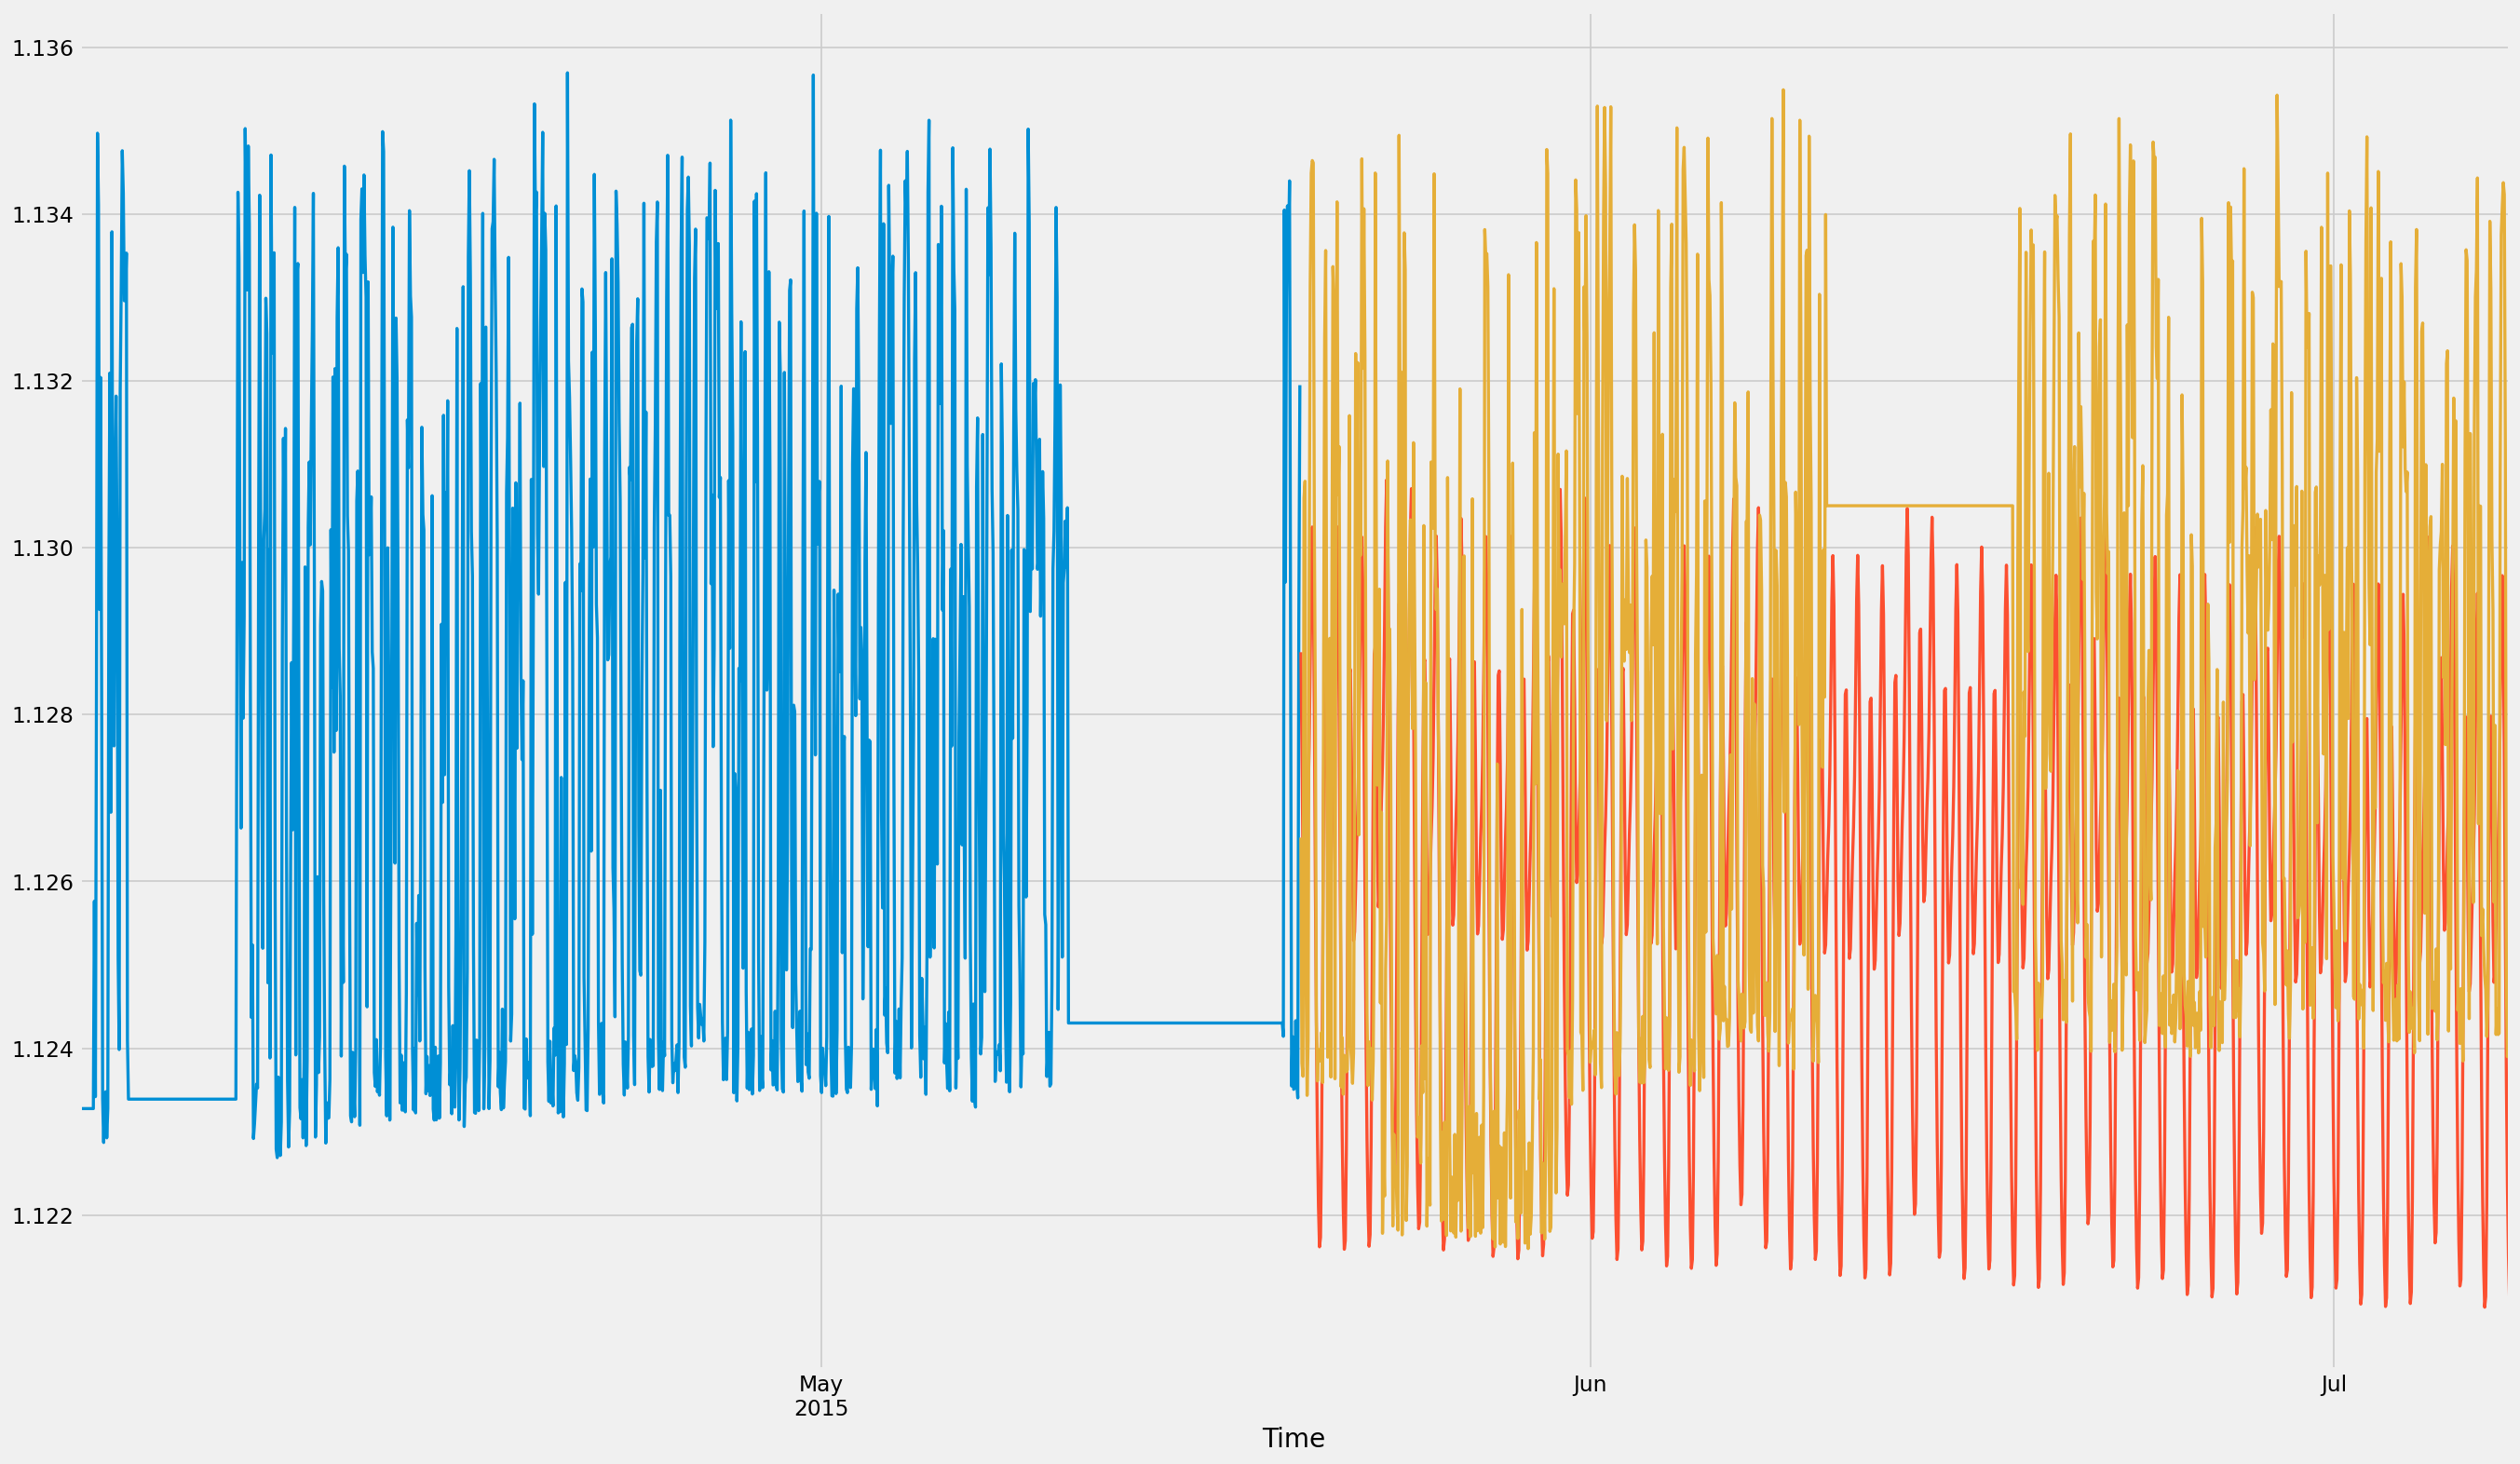

In [223]:
X_train['y'].loc[X_train.index>"2015-04-01"].plot(lw=2, figsize=(25,15))
prediction['yhat'].plot(lw=2, figsize=(25,15))
X_test['Agg_transformed'].plot(lw=2, figsize=(25,15))

<AxesSubplot:xlabel='Time'>

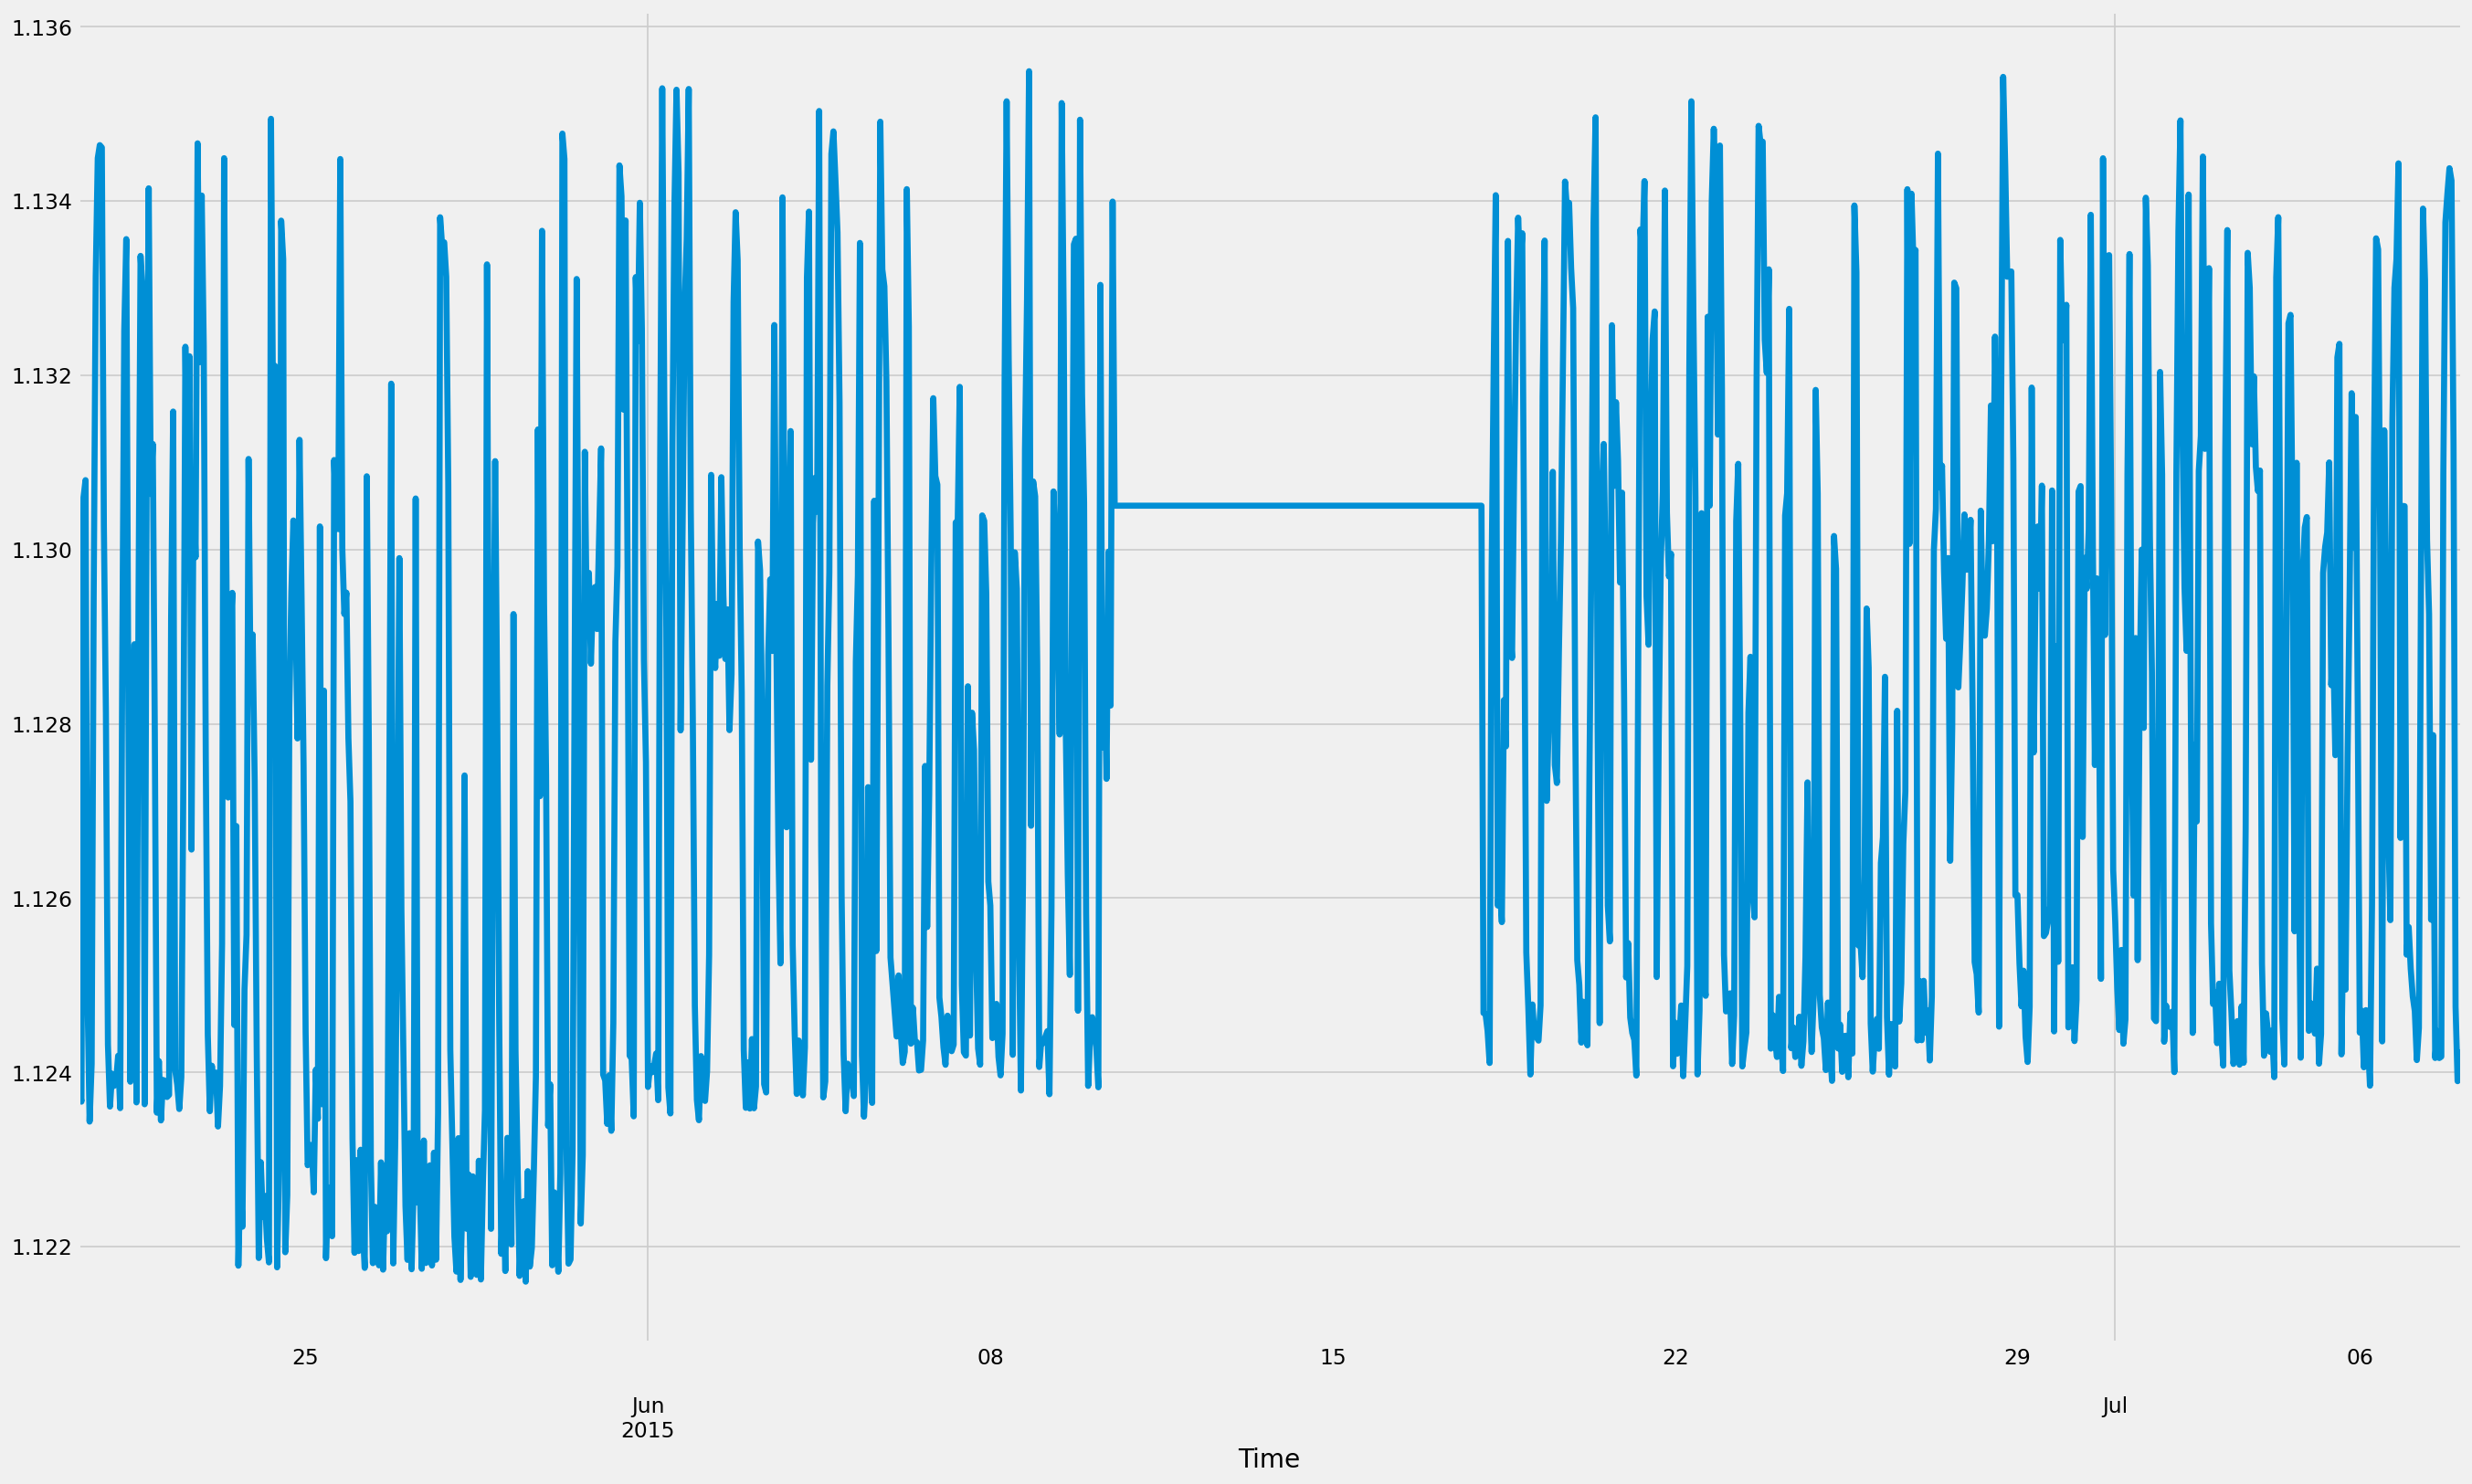

In [207]:
X_test['Agg_transformed'].plot(lw=4, figsize=(25,15))

In [229]:
#Cross validation
from prophet.diagnostics import cross_validation
from ipywidgets import IntProgress

## XGBoost

In [127]:
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

import re
from colorama import Fore, Back, Style
import plotly.express as px
from matplotlib.patches import Patch

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

In [128]:
# train, test split
# split into train and test sets
values = refit['house_0'].values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.8, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
print(X_train.shape)

(5797, 1, 1)


In [129]:
X_train = X_train.reshape(X_train.shape[0],1)
X_test = X_test.reshape(X_test.shape[0],1)

In [130]:
reg = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.001, 0.01, .005], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}


In [133]:
reg.fit(X_train, y_train,verbose=False) # Change verbose to True if you want to see it train

XGBoostError: [18:35:43] /Users/runner/work/xgboost/xgboost/src/data/data.cc:367: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000012f74e4a4 dmlc::LogMessageFatal::~LogMessageFatal() + 116
  [bt] (1) 2   libxgboost.dylib                    0x000000012f799866 xgboost::MetaInfo::SetInfo(char const*, void const*, xgboost::DataType, unsigned long) + 310
  [bt] (2) 3   libxgboost.dylib                    0x000000012f741686 XGDMatrixSetDenseInfo + 150
  [bt] (3) 4   libffi.7.dylib                      0x000000010a9daead ffi_call_unix64 + 85
  [bt] (4) 5   ???                                 0x00007ff7b5afddb0 0x0 + 140701881851312



In [99]:
from xgboost import plot_importance, plot_tree

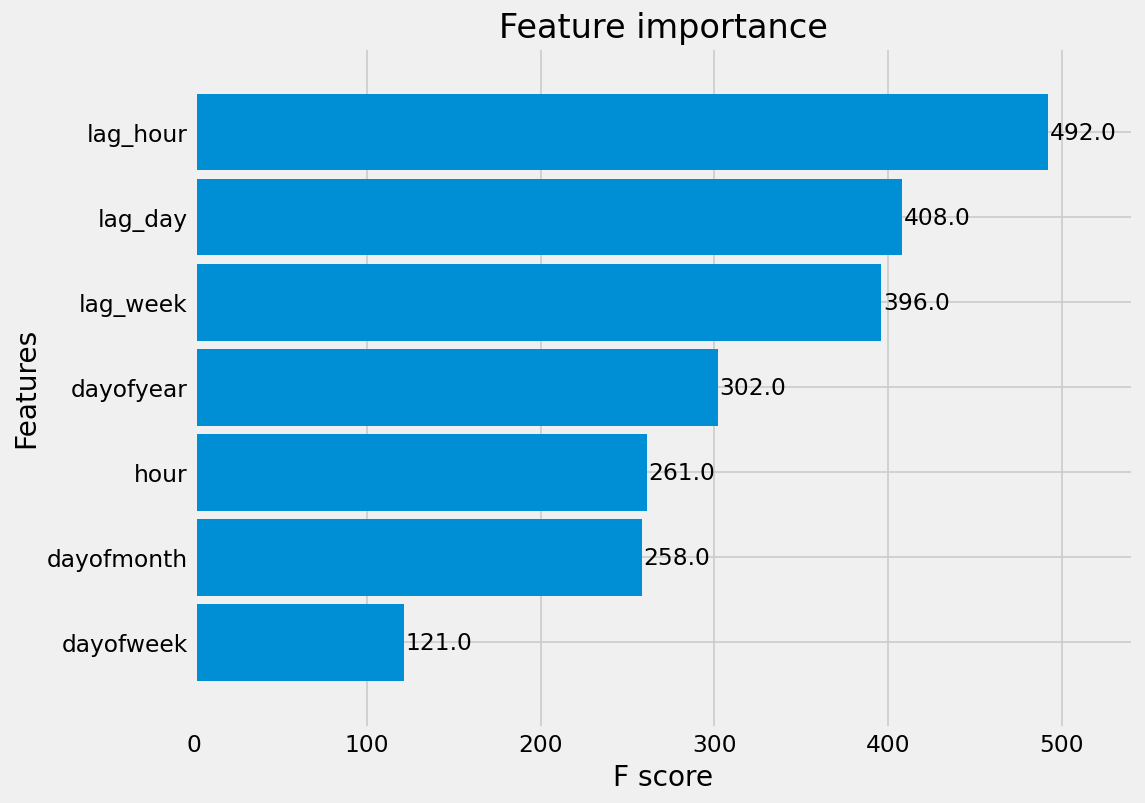

In [100]:
_ = plot_importance(reg, height=0.9)

In [110]:
X_test[nums.columns] = scaler.transform(X_test[nums.columns])

ValueError: X has 3 features, but MinMaxScaler is expecting 1 features as input.

In [101]:
X_test['Prediction'] = reg.predict(X_test)

In [106]:
y_test= y_test.reshape(-1,1)
y_test = scaler.transform(y_test)

In [107]:
X_test['actual'] = y_test

In [108]:
X_test

,dayofmonth,dayofyear,month,quarter,dayofweek,hour,lag_hour,lag_day,lag_week,Prediction,actual
Time,,,,,,,,,,,
2015-04-01 14:00:00,1,91,4,2,2,14,153.953125,153.953125,183.304950,0.413364,153.953125
2015-04-01 15:00:00,1,91,4,2,2,15,153.953125,153.953125,156.031621,0.413364,153.953125
2015-04-01 16:00:00,1,91,4,2,2,16,153.953125,153.953125,320.498039,0.413364,194.458599
2015-04-01 17:00:00,1,91,4,2,2,17,194.458599,153.953125,384.061144,0.413364,155.847222
2015-04-01 18:00:00,1,91,4,2,2,18,155.847222,153.953125,226.865347,0.413364,263.071918
...,...,...,...,...,...,...,...,...,...,...,...
2015-07-07 22:00:00,7,188,7,3,1,22,1050.237052,370.565815,372.911243,0.504051,424.424361
2015-07-07 23:00:00,7,188,7,3,1,23,424.424361,186.427451,206.452055,0.504051,175.826772
2015-07-08 00:00:00,8,189,7,3,2,0,175.826772,192.558000,193.706349,0.413364,162.523529


<AxesSubplot:xlabel='Time'>

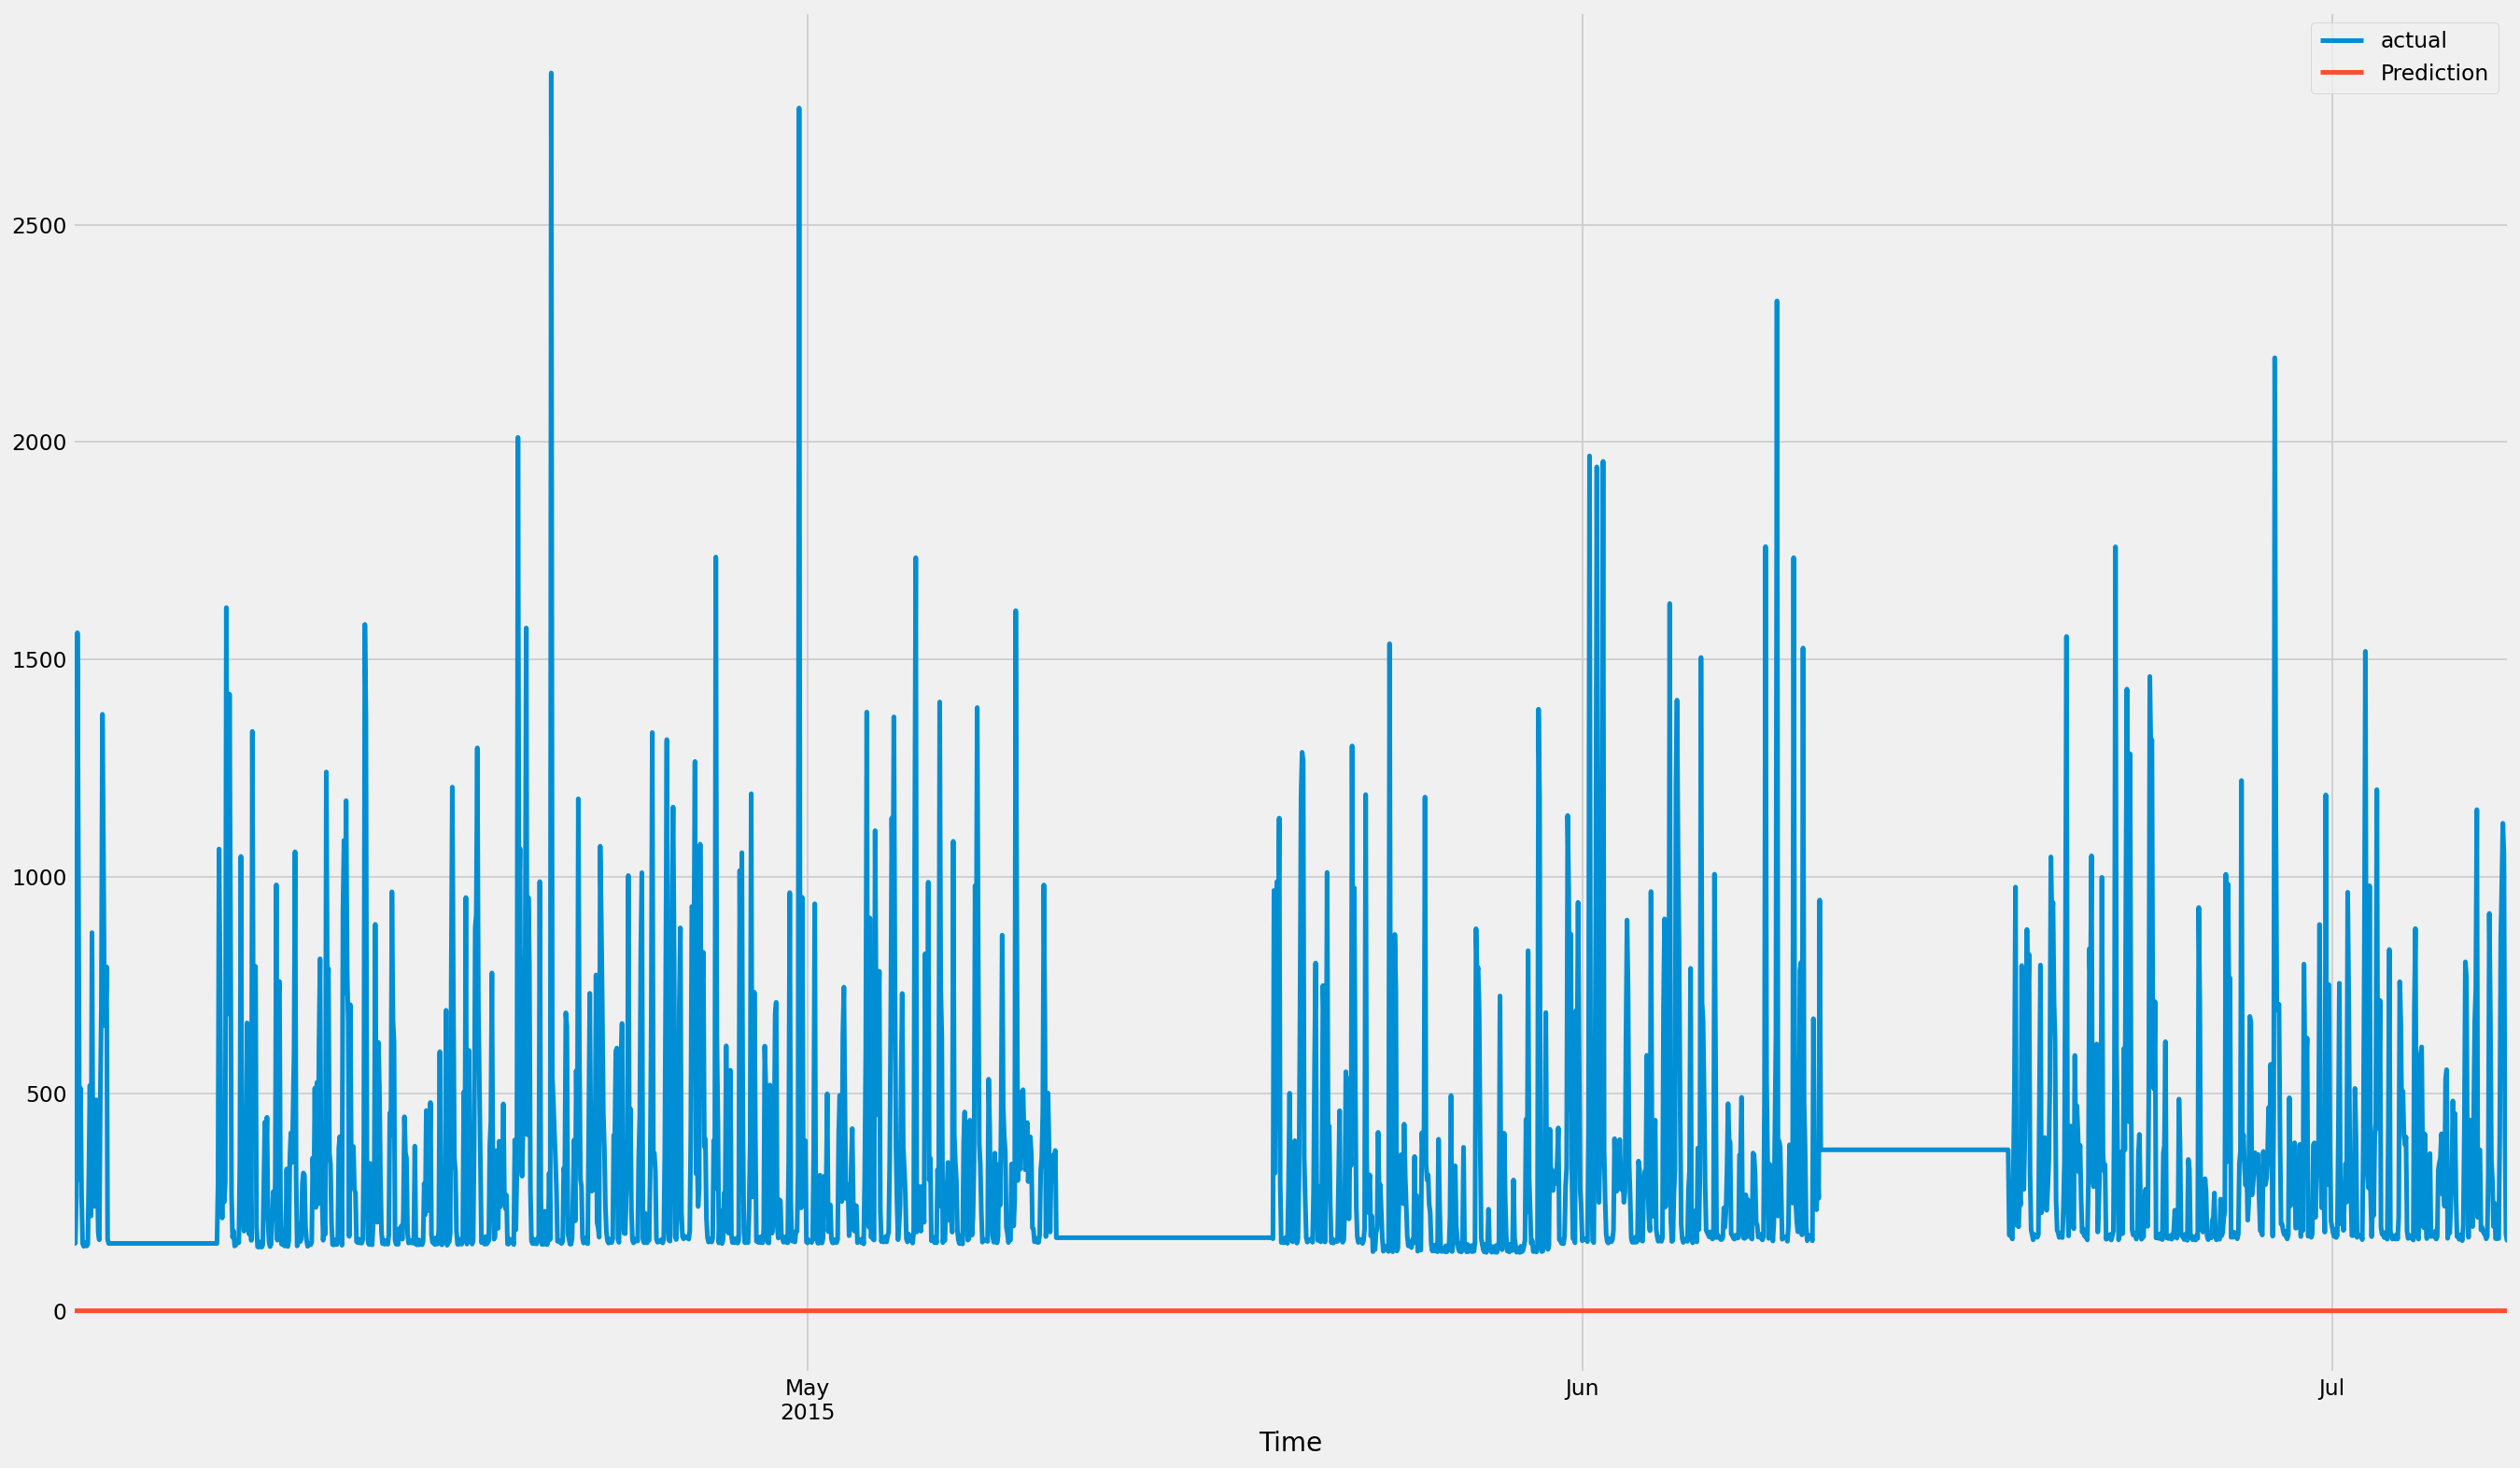

In [109]:
X_test[['actual','Prediction']].plot(lw=3, figsize=(25,15))
#X_test[['actual','Prediction']].loc[(X_test.index>'2015-07-01')&(X_test.index<="2015-08-01")].plot(lw=1)

In [310]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(X_test['actual'], X_test['Prediction'])


6.801784154011548e-06

In [311]:


mean_absolute_error(X_test['actual'], X_test['Prediction'])

0.0019872941795379406

In [313]:
X_test['error']= X_test['actual']-X_test['Prediction']
X_test['abs_error'] = X_test['error'].apply(np.abs)

In [316]:
error_by_day = X_test.groupby(['month','dayofmonth']) \
    .mean()[['actual','Prediction','error','abs_error']]

In [324]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(25)

actual  Prediction     error  abs_error
month dayofmonth                                           
4     3           1.123419    1.125550 -0.002131   0.002197
5     16          1.124302    1.125914 -0.001612   0.002009
4     4           1.123390    1.124946 -0.001557   0.001618
5     11          1.124302    1.125817 -0.001515   0.001953
      17          1.124302    1.125696 -0.001394   0.001849
4     5           1.123390    1.124775 -0.001385   0.001466
      6           1.123390    1.124739 -0.001350   0.001412
5     12          1.124302    1.125566 -0.001264   0.001786
      13          1.124302    1.125557 -0.001255   0.001714
      14          1.124302    1.125509 -0.001206   0.001653
      26          1.124144    1.125337 -0.001192   0.002456
      15          1.124302    1.125384 -0.001082   0.001558
6     24          1.126022    1.127067 -0.001046   0.001844
5     28          1.124179    1.125049 -0.000870   0.001992
      29          1.124375    1.125185 -0.000809   0.001893
4     15          1.125689    1.126465 -0.000775   0.002056
6     7           1.126475    1.127215 -0.000739   0.002167
5     18          1.124302    1.124860 -0.000558   0.001184
6     25          1.126156    1.126654 -0.000498   0.001967
5     27          1.125122    1.125501 -0.000379   0.001959
6     6           1.126553    1.126887 -0.000334   0.001887
5     23          1.126140    1.126388 -0.000248   0.002315
6     26          1.126915    1.127134 -0.000219   0.001965
5     1           1.126368    1.126506 -0.000138   0.001633
4     24          1.127247    1.127379 -0.000132   0.001859

In [325]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

actual  Prediction     error  abs_error
month dayofmonth                                           
4     2           1.128882    1.126884  0.001999   0.002904
5     31          1.128620    1.127832  0.000789   0.002817
      24          1.126935    1.126506  0.000429   0.002815
4     1           1.128288    1.126957  0.001331   0.002803
      8           1.128244    1.126914  0.001330   0.002769
      25          1.127998    1.127538  0.000460   0.002621
5     30          1.126519    1.126107  0.000412   0.002565
4     10          1.126975    1.126479  0.000496   0.002509
6     29          1.127707    1.127399  0.000308   0.002504
5     3           1.127622    1.127571  0.000051   0.002485